# __Evaluating alternate regression models__

## W. W. Supplee 2020

In [1]:
import pandas as pd
import scipy
import numpy as np
import random
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import graphviz
import xgboost as xgb
import sys
%matplotlib inline


In [2]:
data = pd.read_parquet('./linearmodel-sqft.parquet')

In [3]:
# Split our data into independent and dependent variables and remove any rows with missing numerical data
X = data.loc[:,['bedrooms','bathrooms','sqft','latitude','longitude','pets','laundry','parking','EV_charging']]
y = data.loc[:,['price']]

In [4]:
print(y.describe())
X.head()

             price
count  1433.000000
mean   3307.297278
std     872.382834
min     899.000000
25%    2680.000000
50%    3200.000000
75%    3784.000000
max    6600.000000


,bedrooms,bathrooms,sqft,latitude,longitude,pets,laundry,parking,EV_charging
0,2,1,950.0,37.395954,-122.067890,False,True,True,False
1,1,1,717.0,37.664634,-122.463684,True,True,True,False
2,3,3,1425.0,37.562354,-122.285813,True,True,True,True
3,1,1,807.0,37.558650,-122.285651,True,True,True,False
4,1,1,807.0,37.558650,-122.285651,True,True,True,True


In [270]:
rmse = np.array([])
alpha = np.array([])
trees = np.array([])
for i in range(1,60,1):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror',\
             colsample_bytree=1,\
             max_depth=5,\
             reg_alpha=30,\
             learning_rate=0.3,\
             n_estimators=i)
    xg_reg.fit(X_train,y_train)
    predictions = xg_reg.predict(X_test)
    rmse_xgb = np.sqrt(mean_squared_error(predictions,y_test))
    rmse=np.append(rmse,rmse_xgb)
    alpha=np.append(alpha,30)
    trees=np.append(trees,i)
regSeries = pd.DataFrame({'alpha':alpha, 'trees':trees, 'rmse':rmse})

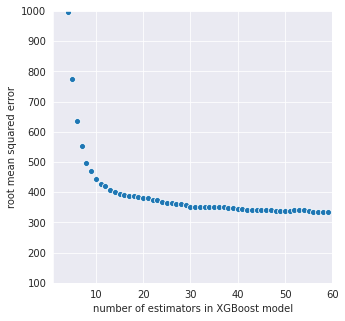

In [272]:
plt.rcParams['figure.figsize'] = [5,5]
plt.ylim(100,1000)
plt.xlim(1,60)
ax=sns.scatterplot(x='trees',y='rmse',data=regSeries)
plt.xlabel("number of estimators in XGBoost model")
plt.ylabel("root mean squared error")
plt.show()

In [293]:
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, KFold
from scipy import stats

params = {"objective":"reg:squarederror",'colsample_bytree': 1,'learning_rate': 0.3,
                'max_depth': 5, 'alpha': 30}
xgb_model = xgb.XGBRegressor(params=params)
#param_dist = {"objective":["reg:squarederror"],'colsample_bytree': stats.uniform(0.0,1.0),'learning_rate': stats.uniform(0,1),\
#                'max_depth': [3,4,5,6,7], 'alpha': stats.uniform(0,60)}
#reg = RandomizedSearchCV(xgb_model,param_distributions=param_dist,n_iter=25, scoring='neg_mean_squared_error',error_score=0,verbose=3,n_jobs=-1)

numFolds=10
folds = KFold(n_splits = numFolds, shuffle=False)

estimators= []
results = np.zeros(len(X))
score=0.0

for train_index, test_index in folds.split(X):
    X_train,X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train,y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    xgb_model.fit(X_train,y_train)
    results[test_index] = reg.predict(X_test)
    score += mean_squared_error(y_test, results[test_index])
score /= numFolds
score = score ** 0.5

#data[data['latitude']]
print("RMSE for the XGBoost model is", score)

#data = data.loc[notnanIndex,:]
#data = data.assign(predicted_xgb=results)

RMSE for the XGBoost model is 143.01860784665115


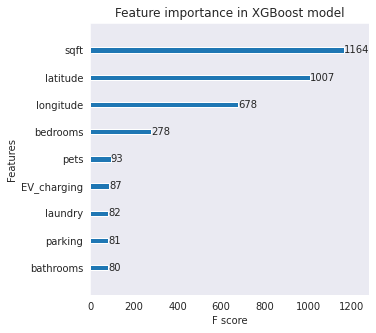

In [298]:
notnanIndex = data['latitude'].dropna().index
data=data.loc[notnanIndex,:]
data=data.assign(predicted_xgb=results)
residuals_xgb = data.price - data.predicted_xgb
data=data.assign(residual_xgb=residuals_xgb)
#plt.style.use('default')
plt.rcParams['figure.figsize'] = [5, 5]
xgb.plot_importance(xgb_model)
plt.title('Feature importance in XGBoost model')
plt.grid(b=None)
plt.show()

In [299]:
data['rmse_lin'] = data.apply(lambda x : np.sqrt(x.residual**2),axis=1)
data['rmse_xgb'] = data.apply(lambda x : np.sqrt(x.residual_xgb**2),axis=1)

In [300]:
modelresults=data.loc[:,['bedrooms','bathrooms','pets','laundry','EV_charging','parking','sqft','price','predicted','predicted_xgb','residual','residual_xgb']]

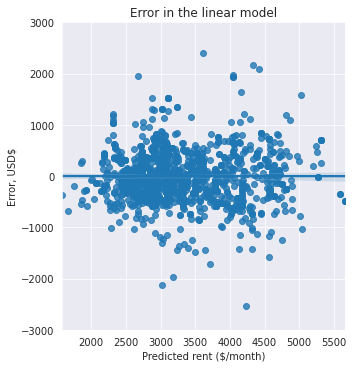

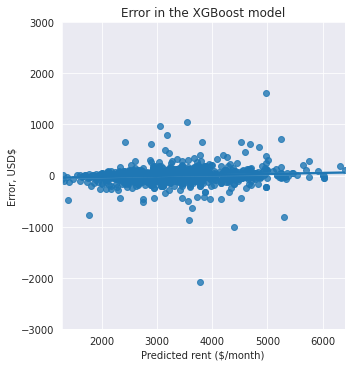

In [301]:
sns.set_style('darkgrid')
sns.lmplot(x='predicted',y='residual',data=modelresults)
plt.title("Error in the linear model")
plt.ylabel('Error, USD$')
plt.xlabel('Predicted rent ($/month)')
plt.ylim(-3000,3000)
plt.show()
ax2=sns.lmplot(x='predicted_xgb',y='residual_xgb',data=modelresults)
plt.title("Error in the XGBoost model")
plt.ylabel('Error, USD$')
plt.xlabel('Predicted rent ($/month)')
plt.ylim(-3000,3000)
plt.show()

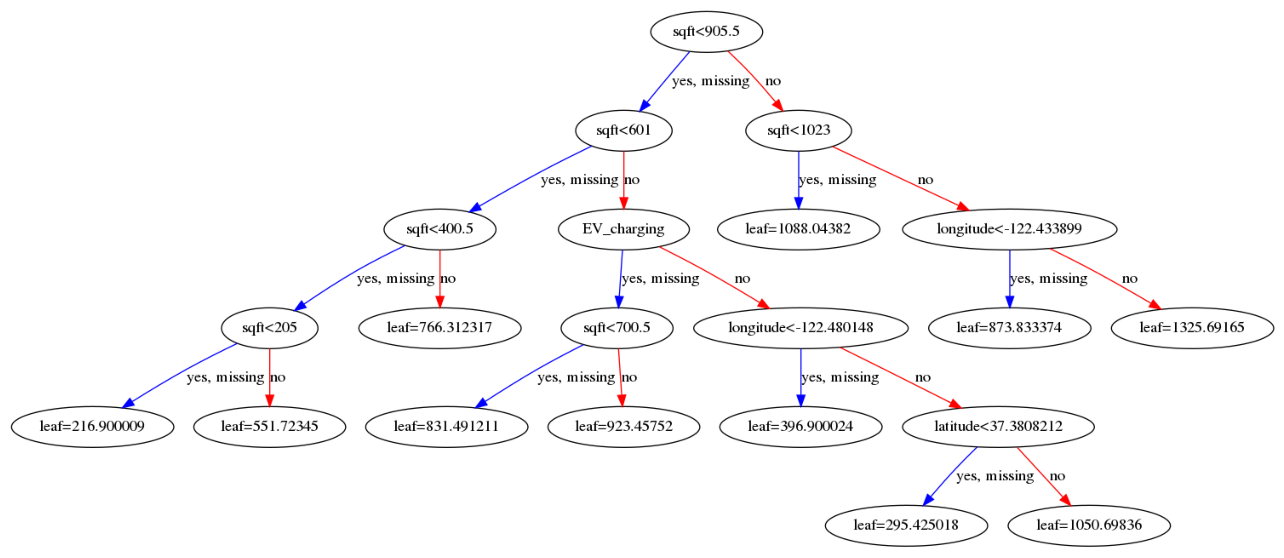

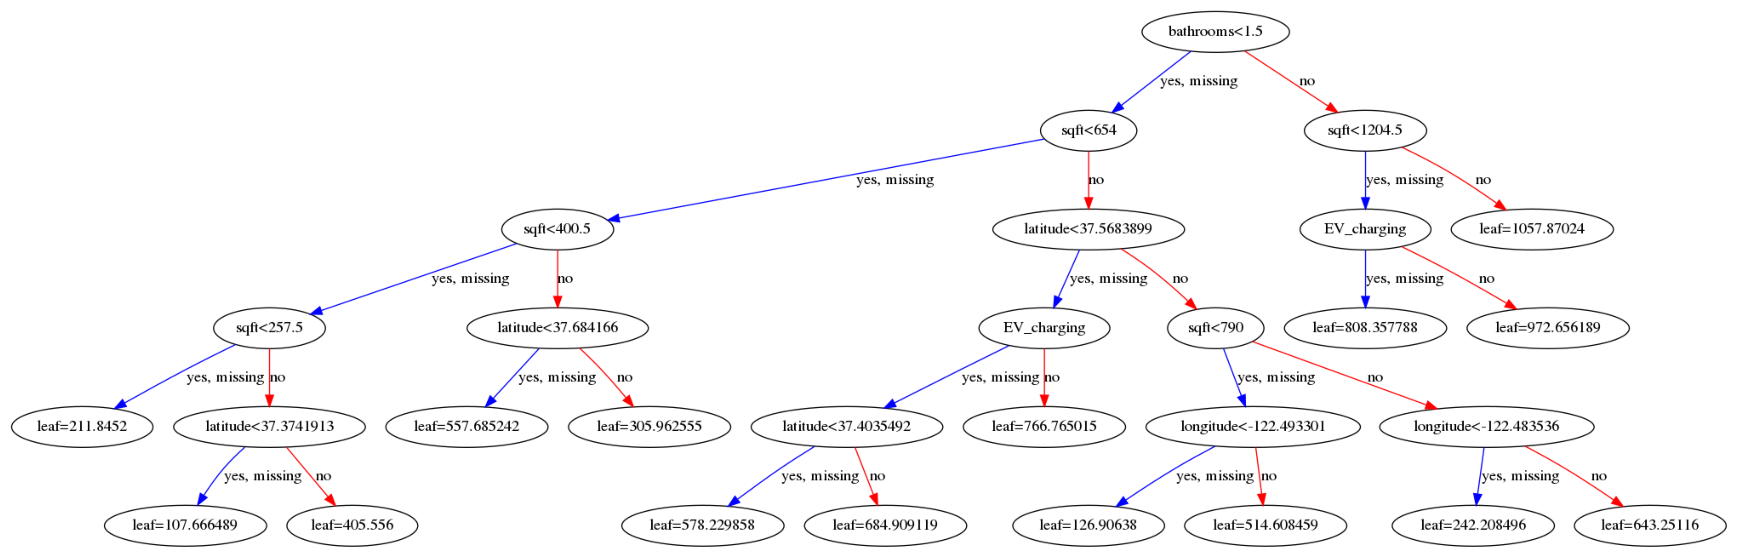

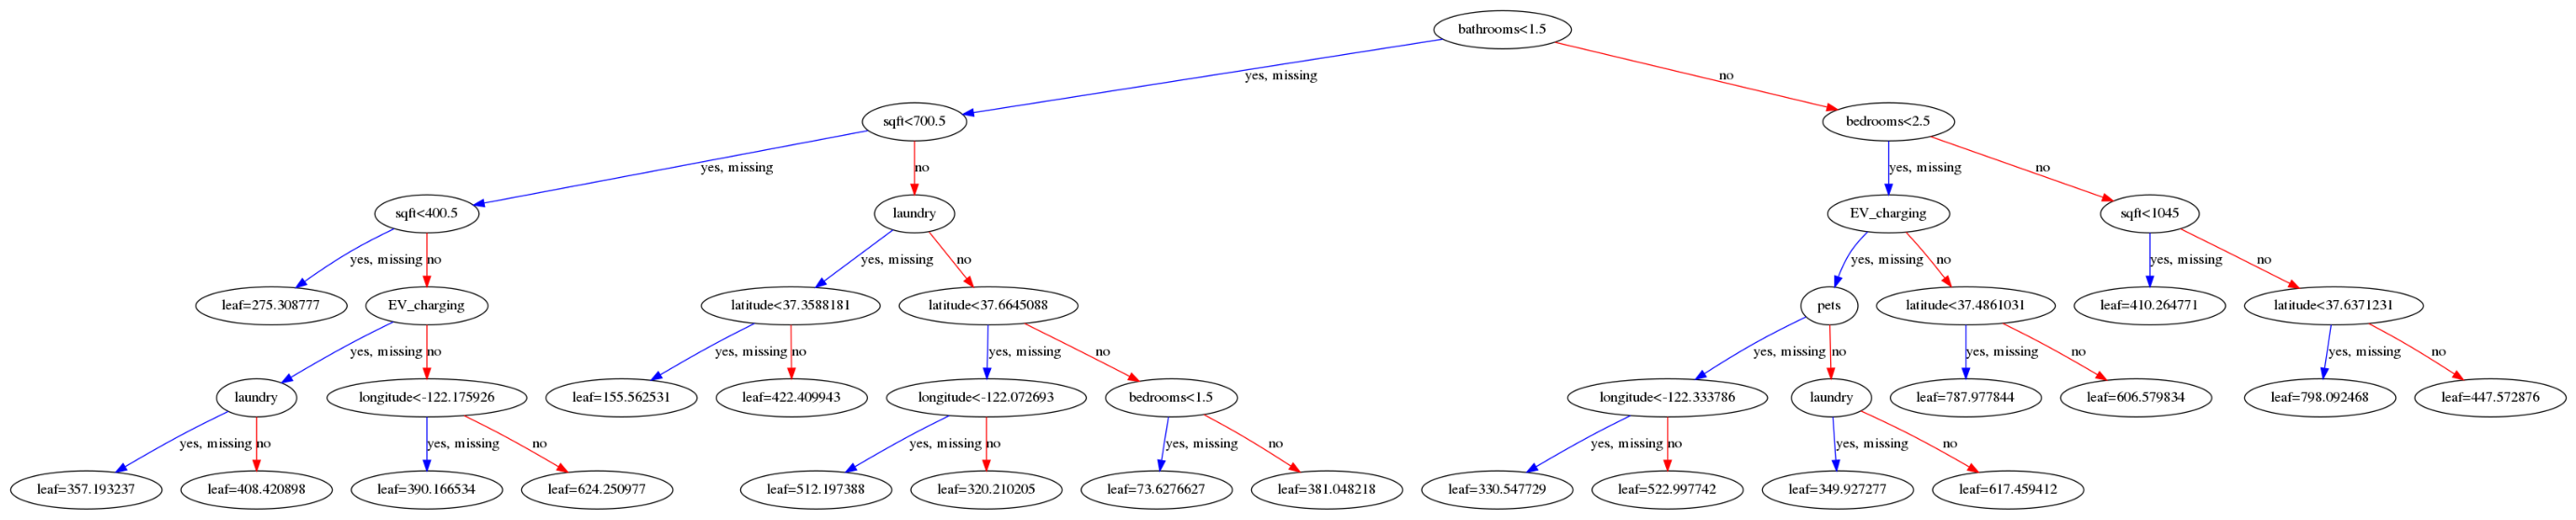

In [303]:
plt.rcParams['figure.figsize'] = [50, 10]
for i in range(0,3):
    xgb.plot_tree(xg_reg,num_trees=i)
    plt.show()

In [14]:
data.to_csv('debugmodels.csv')

In [15]:
file=open('xgb_sqft.model','wb')
pickle.dump(xg_reg,file)
file.close()

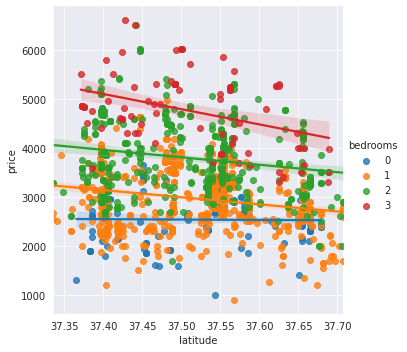

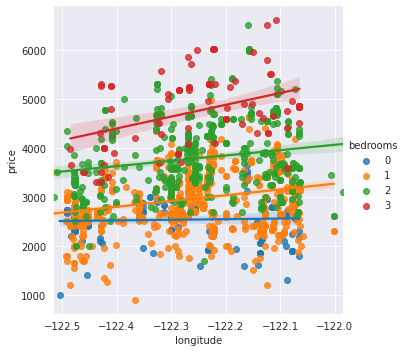

In [308]:
plt.rcParams['figure.figsize'] = [5, 5]
sns.lmplot(x='latitude',y='price',hue='bedrooms',data=data)
plt.show()
sns.lmplot(x='longitude',y='price',hue='bedrooms',data=data)
plt.show()

In [17]:
data.rmse_xgb.describe()

count    1433.000000
mean      108.680773
std       127.387832
min         0.015137
25%        27.614258
50%        64.811035
75%       144.082764
max       992.042969
Name: rmse_xgb, dtype: float64

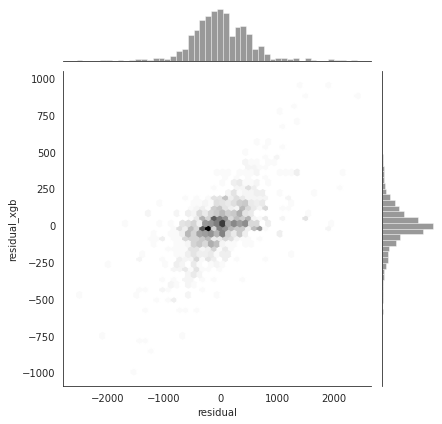

In [18]:
with sns.axes_style("white"):
    sns.jointplot(x=data.residual, y=data.residual_xgb, kind="hex", color="k");

In [19]:
modelAccuracy = data.loc[:,['residual','residual_xgb','rmse_lin','rmse_xgb']]

In [20]:
modelAccuracy.rename(columns={'residual':'residual_lin'},inplace=True)
modelAccuracy.describe()

,residual_lin,residual_xgb,rmse_lin,rmse_xgb
count,1.433000e+03,1433.000000,1433.000000,1433.000000
mean,2.493780e-11,-0.015437,359.849744,108.680773
std,4.847837e+02,167.473634,324.704429,127.387832
min,-2.541047e+03,-992.042969,0.639975,0.015137
25%,-2.859915e+02,-57.676270,125.098045,27.614258
50%,-2.491752e+01,0.401855,291.793872,64.811035
75%,3.037768e+02,68.041260,479.672110,144.082764
max,2.411763e+03,948.402100,2541.046769,992.042969


In [304]:
def percentCorrect(data,margin=150,label='linear'):
    series=data.to_list()
    count=0
    for s in series:
        if s<margin:
           count += 1
    pct=count/len(series)
    return pct

In [305]:
results=[]
models={'linear':'lin','xgboost':'xgb'}
for i in range(500,0,-100):
    for key in models:
        columnName = 'rmse_'+models[key]
        pct=percentCorrect(modelAccuracy[columnName],margin=i,label=key)
        results.append((key,i,pct))
        if i==100:
            columnName = 'rmse_'+models[key]
            pct=percentCorrect(modelAccuracy[columnName],margin=50,label=key)
            results.append((key,50,pct))
            
        

In [306]:
rmsePlot = pd.DataFrame(results,columns=['model','dollars','percent'])

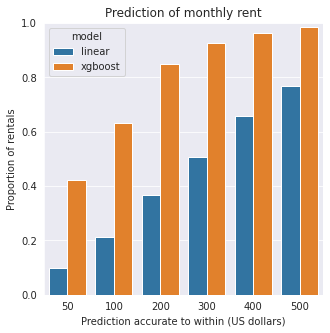

In [311]:
plt.xlim(500,0)
plt.ylim(0,1)
plt.title('Prediction of monthly rent')
ax=sns.barplot(x='dollars',y='percent',hue='model',data=rmsePlot)
plt.xlabel('Prediction accurate to within (US dollars)')
plt.ylabel('Proportion of rentals')
plt.show()

In [25]:
#X[type(X['latitude'].values) == 'float64'].index
notnanIndex = X['latitude'].dropna().index
X=X.loc[notnanIndex,:]
y=y.loc[notnanIndex,:]
if len(X) != len(y):
    print("Houston, we have a problem here!",X.shape,y.shape)

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
#y = np.column_or_1d(y,warn=True)
kBest=SelectKBest(mutual_info_regression,k=4).fit(X,y.values.ravel())
columns=kBest.get_support(indices=True)
X_best = X.iloc[:,columns]
print(X_best.columns)

Index(['bedrooms', 'sqft', 'latitude', 'longitude'], dtype='object')


In [227]:
import sklearn
from sklearn import preprocessing
import time
latitude_radians = X_best.latitude / 180 * np.pi
longitude_radians = X_best.longitude / 180 * np.pi
X_best=X_best.assign(longitude_radians=longitude_radians,latitude_radians=latitude_radians)

def best_distance(a,b):
    # bedrooms/0, sqft/1, latitude/2, longitude/3, latitude_radians/4, longitude_radians/5
    geographic=((a[5] - b[5])**2 + (a[4]-b[4])**2)**(1/2)
    sqft=((a[1]-b[1])**2)**0.5
    bedrooms=((a[0]-b[0])**2)**0.5
    w1=750
    w2=650
    w3=60
    return w1*geographic+w2*sqft+w3*bedrooms

scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(X_best)
scaled = pd.DataFrame(scaled,columns=['bedrooms','sqft','latitude','longitude','latitude_radians','longitude_radians'])

scaled_train, scaled_test, y_train, y_test = train_test_split(scaled,y,test_size=0.10,random_state=0)
KNN2 = sklearn.neighbors.KNeighborsRegressor(n_neighbors=4,weights='distance',metric=best_distance,algorithm='auto')
KNN2.fit(scaled_train,y_train)

predictions=KNN2.predict(scaled_test)
residuals=y_test.values-predictions
scaled_test=scaled_test.assign(price=y_test.values,predicted=predictions,residual=residuals)
print("RMSE is ",np.sqrt(mean_squared_error(predictions,y_test)))

RMSE is  430.0245187197152


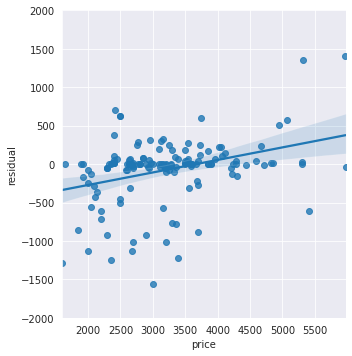

In [228]:
ax=sns.lmplot(x='price',y='residual',data=scaled_test)
plt.ylim(-2000,2000)
plt.show()

,price,predicted,residuals
1726,3550,2801.551915,748.448085
565,4673,4135.499089,537.500911
2134,4211,3597.000000,614.000000


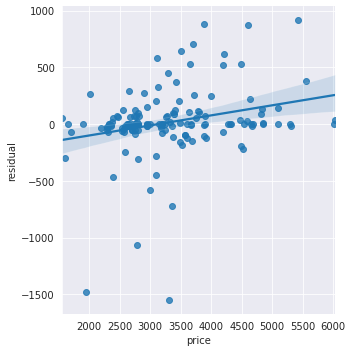

In [155]:
sns.lmplot(x='price',y='residual',data=scaled_test)

In [328]:
xg_reg.fit(X,y)
X.columns
myAptData={'bedrooms':[1],\
           'bathrooms':[1],\
           'sqft':[690],\
           'latitude':[37.391],\
           'longitude':[-122.0703],\
           'pets':[True],\
           'laundry':[True],\
           'parking':[True],\
           'EV_charging':[True]}
myApt = pd.DataFrame(data=myAptData)
myAptValue=xg_reg.predict(myApt)
myAptValue

array([3487.3442], dtype=float32)